# SBTi Temperature Alignment tool examples
This notebook provides some examples on how to use the SBTi Temperature Alignment tool.

### Install the SBTi Python module
This is only required if you didn't already instally the module.

In [ ]:
!pip install SBTi

In [1]:
import SBTi
from SBTi.data.excel import ExcelProvider
from SBTi.portfolio_aggregation import PortfolioAggregationMethod
from SBTi.portfolio_coverage_tvp import PortfolioCoverageTVP
from SBTi.temperature_score import TemperatureScore, Scenario, ScenarioType
from SBTi.target_validation import TargetProtocol
from SBTi.interfaces import ETimeFrames, EScope
import pandas as pd

### Download the dummy data provider

In [2]:
import urllib.request
import os

if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/data_provider_example.xlsx"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/data/data_provider_example.xlsx", "data/data_provider_example.xlsx")
if not os.path.isfile("example_portfolio.csv"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/example_portfolio.csv", "example_portfolio.csv")

#### Logging
The SBTi module uses the Python standard library logging utilities to send log messages. The log level can be changed according to the user's needs.

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel("INFO")

### Create a data provider
Data providers let you connect to the data source of your choice.

In [4]:
provider = ExcelProvider(path="data/data_provider_example.xlsx")

### Load your portfolio
In our case the portfolio is stored as a CSV file. The portfolio should at least have an "id" (the identifier of the company) and a "proportion" (the weight of the company in your portfolio e.g. the value of the shares you hold) column.

In [5]:
portfolio = pd.read_csv("example_portfolio.csv", encoding="iso-8859-1")

In [6]:
portfolio.head(5)

,company_name,company_id,ISIN,weights,investment_value,engagement_target
0,"Advanced Micro Devices, Inc",US0079031078,US0079031078,6.36%,35000000,1.0
1,Adobe Systems Inc.,US00724F1012,US00724F1012,1.82%,10000000,NaN
2,Capgemini Group,FR0000125338,FR0000125338,1.82%,10000000,NaN
3,"Cisco Systems, Inc.",US17275R1023,US17275R1023,1.82%,10000000,NaN
4,Coca-Cola HBC AG,CH0198251305,CH0198251305,1.82%,10000000,NaN


To load the data from the data provider, we have to pass a list of dictionaries, containing a "company_name" and "company_id".

In [7]:
portfolio["company_isin"] = portfolio.ISIN
companies = [SBTi.interfaces.PortfolioCompany.parse_obj(company) for company in portfolio.to_dict(orient="records")]
print(portfolio.to_dict(orient="records"))

[{'company_name': 'Advanced Micro Devices, Inc', 'company_id': 'US0079031078', 'ISIN': 'US0079031078', 'weights': '6.36%', 'investment_value': 35000000, 'engagement_target': 1.0, 'company_isin': 'US0079031078'}, {'company_name': 'Adobe Systems Inc.', 'company_id': 'US00724F1012', 'ISIN': 'US00724F1012', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'US00724F1012'}, {'company_name': 'Capgemini Group', 'company_id': 'FR0000125338', 'ISIN': 'FR0000125338', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'FR0000125338'}, {'company_name': 'Cisco Systems, Inc.', 'company_id': 'US17275R1023', 'ISIN': 'US17275R1023', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': 'US17275R1023'}, {'company_name': 'Coca-Cola HBC AG', 'company_id': 'CH0198251305', 'ISIN': 'CH0198251305', 'weights': '1.82%', 'investment_value': 10000000, 'engagement_target': nan, 'company_isin': '

### Combine portolio and provider data
We'll call the data provider and ask it to provide us with the targets and the company data. This will take care of all required preprocessing.

In [8]:
portfolio_data = SBTi.utils.get_data([provider], companies)

### Calculate the temperature scores
In the amended portfolio you'll find your original portfolio, amended with the emissions and the temperature score.

In [19]:
temperature_score = TemperatureScore(
    time_frames=list(SBTi.interfaces.ETimeFrames),
    scopes=[EScope.S1S2, EScope.S3, EScope.S1S2S3],
    grouping='sector'
)
amended_portfolio = temperature_score.calculate(portfolio_data)

### Calculate the aggregated temperature score
Calculate an aggregated temperature score. This can be done use different aggregation methods:
- Weighted Average Temperature Score (WATS)
- Total emissions weighted temperature score (TETS)
- Market Owned emissions weighted temperature score (MOTS)
- Enterprise Owned emissions weighted temperature score (EOTS)
- Enterprise Value + Cash emissions weighted temperature score (ECOTS)
- Total Assets emissions weighted temperature score (AOTS)
- Revenue owned emissions weighted temperature score (ROTS)

Here we'll use the "Weighted Average Temperature Score". For more details, have a look at notebook 3 ("3_portfolio_aggregations.ipynb"). The temperature scores are calculated per time-frame/scope combination.

In [11]:
def print_aggregations(aggregations):
    aggregations = aggregations.dict()
    for time_frame, time_frame_values in aggregations.items():
        for scope, scope_values in time_frame_values.items():
            print("{} - {}: {} degrees celcius".format(time_frame, scope, scope_values["all"]["score"]))

In [15]:
temperature_score.aggregation_method = PortfolioAggregationMethod.WATS
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
print_aggregations(aggregated_portfolio)

short - S1S2: 2.2349090909090905 degrees celcius
short - S3: 2.8205454545454542 degrees celcius
short - S1S2S3: 2.670272727272727 degrees celcius
mid - S1S2: 2.7351818181818177 degrees celcius
mid - S3: 3.0340000000000003 degrees celcius
mid - S1S2S3: 2.9639090909090906 degrees celcius
long - S1S2: 3.122181818181818 degrees celcius
long - S3: 3.2258181818181817 degrees celcius
long - S1S2S3: 3.199636363636363 degrees celcius


### Portfolio coverage

Gives insights in the coverage of portfolio entities that have set GHG emissions reduction targets, STBi-validated or otherwise. Companies with SBTi status Approved have a score of 100%, all others have a score of 0%.

In [13]:
portfolio_coverage_tvp = PortfolioCoverageTVP()
coverage = portfolio_coverage_tvp.get_portfolio_coverage(amended_portfolio.copy(), PortfolioAggregationMethod.WATS)
round(coverage * 100) / 100

35.45

## Biggest contributors
- Individual companies
- Companies grouped by regions, countries, sectors, industries

<AxesSubplot:xlabel='company_name'>

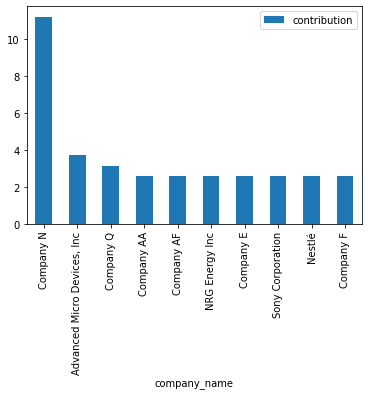

In [16]:
timeframe = 'short'
scope = 'S1S2'
company_names = []
relative_contributions = []
temp_scores = []
for aggregation_contribution in aggregated_portfolio[timeframe][scope]['all']['contributions']:
    company_names.append(aggregation_contribution.company_name)
    relative_contributions.append(aggregation_contribution.contribution_relative)
    temp_scores.append(aggregation_contribution.temperature_score)
df = pd.DataFrame(data={'company_name': company_names, 'contribution': relative_contributions, 'temperature_score': temp_scores})
df = df.merge(right=provider.data['fundamental_data'][['company_name', 'country', 'sector', 'region', 'company_market_cap']],
              how='left',
              on='company_name')
df = df.merge(right=portfolio[['company_name', 'investment_value', 'weights']],
              how='left',
              on='company_name')
df.weights = df.weights.apply(lambda x: float(x[:-1]))
df = df.sort_values(by='contribution', ascending=False)
df[:10].plot.bar(x='company_name', y='contribution')

<AxesSubplot:ylabel='weights'>

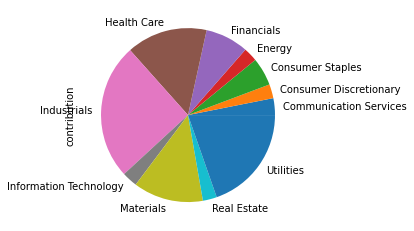

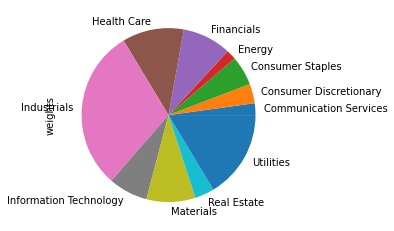

In [17]:
plt.figure()
df.groupby('sector').contribution.sum().plot.pie()
plt.figure()
df.groupby('sector').weights.sum().plot.pie()
# Write function that takes as input the grouped variable
# As output it gives:
# - a bar plot of the temp scores per category
#       (with aggregated_portfolio grouped - need to extract)
# - a pie chart of the investment values (= portfolio %)
#       (with df.groupby)
# - a pie chart of the contributions (with df.groupby)
# Stats can simply be produced by changing the groupby variable

## Companies to engage

In [18]:
df['ownership_percentage'] = 100 * df['investment_value'] / df['company_market_cap']
df[['company_name', 'contribution', 'temperature_score', 'ownership_percentage', 'weights']][:10]

,company_name,contribution,temperature_score,ownership_percentage,weights
0,Company N,11.194273,3.2,0.189087,7.82
1,"Advanced Micro Devices, Inc",3.701595,1.3,0.334454,6.36
2,Company Q,3.123983,3.2,4.811121,2.18
16,Company AA,2.603319,3.2,0.073838,1.82
29,Company AF,2.603319,3.2,0.974571,1.82
28,NRG Energy Inc,2.603319,3.2,0.136632,1.82
27,Company E,2.603319,3.2,3.386608,1.82
26,Sony Corporation,2.603319,3.2,1.504369,1.82
25,Nestlé,2.603319,3.2,0.369487,1.82
23,Company F,2.603319,3.2,0.109647,1.82


### Scenarios
To determine the effect of engaging (part of) your portfolio, you can run a number of scenarios:
 - 1: Engage companies to set targets. This means that the default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 2: Engage companies to have their targets validated by the SBTi. This means that the maximum score for all targets will be capped at 1.75 degrees celcius.
 - 3a: engage the top 10 contributors to set targets. This means that their default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 3b: engage the top 10 contributors to have their targets validated by the SBTi. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.
 - 4a: engage the predefined companies to set targets. This means that their default score (i.e. the score when a company didn't set a target) will be set to 2 degrees celcius.
 - 4b: engage the predefined companies to have their targets validated by the SBTi. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.

In this example, we'll determine the effect of our scenario's by looking at the aggregated temperature score for the short timeframe in the combined s1s2s3 scope. Of course you can use multiple, or different criteria.

In [ ]:
# See if it's possible to do scenario 4a:
# - Set portfolio['engagement_target'] to 1 for given companies
# - Rerun portfolio_data creation
# - Assign Scenario
# - Compute temperature scores

In [ ]:
scenario = Scenario()
scenario.scenario_type = ScenarioType.TARGETS
scenario.engagement_type = None
scenario.aggregation_method = PortfolioAggregationMethod.WATS
scenario.grouping = None

In [ ]:
temperature_score = TemperatureScore(time_frames=time_frames, scopes=scopes, scenario=scenario, aggregation_method=PortfolioAggregationMethod.WATS)
scenario_one = temperature_score.calculate(portfolio_data.copy())
scenario_aggregated = temperature_score.aggregate_scores(scenario_one)
print_aggregations(scenario_aggregated)

In [ ]:
portfolio_coverage_tvp = PortfolioCoverageTVP()
coverage = portfolio_coverage_tvp.get_portfolio_coverage(amended_portfolio.copy(), PortfolioAggregationMethod.WATS)
round(coverage * 100) / 100

In [ ]:
# Use previously defined plotting function with groupby etc.
# to plot same graphs as before to see effect of scenario.

### Save anonymized data for SBTi target validation
In order for the targets to be validated by SBTi, you can save your data locally. By running the anonymize function, you can replace company identifiers with meaningless substitutes.

In [ ]:
def anonymize(portfolio, provider):
    portfolio_companies = portfolio['company_name'].unique()
    for index, company_name in enumerate(portfolio_companies):
        portfolio.loc[portfolio['company_name'] == company_name, 'company_id'] = 'C' + str(index + 1)
        portfolio.loc[portfolio['company_name'] == company_name, 'company_isin'] = 'C' + str(index + 1)
        provider.data['fundamental_data'].loc[provider.data['fundamental_data']['company_name'] == company_name, 'company_id'] = 'C' + str(index + 1)
        provider.data['fundamental_data'].loc[provider.data['fundamental_data']['company_name'] == company_name, 'company_isic'] = 'C' + str(index + 1)
        provider.data['target_data'].loc[provider.data['target_data']['company_name'] == company_name, 'company_id'] = 'C' + str(index + 1)
        portfolio.loc[portfolio['company_name'] == company_name, 'company_name'] = 'Company' + str(
            index + 1)
        provider.data['fundamental_data'].loc[provider.data['fundamental_data']['company_name'] == company_name, 'company_name'] = 'Company' + str(
                    index + 1)
        provider.data['target_data'].loc[provider.data['target_data']['company_name'] == company_name, 'company_name'] = 'Company' + str(
                    index + 1)
    for index, company_name in enumerate(provider.data['fundamental_data']['company_name'].unique()):
        if company_name not in portfolio['company_name'].unique():
            provider.data['fundamental_data'].loc[provider.data['fundamental_data']['company_name'] == company_name, 'company_id'] = '_' + str(index + 1)
            provider.data['fundamental_data'].loc[provider.data['fundamental_data']['company_name'] == company_name, 'company_name'] = 'Company_' + str(
                                index + 1)
    return portfolio, provider

In [ ]:
portfolio, provider = anonymize(portfolio, provider)

In order to store the portfolio and provider data locally, two options apply.
If you use the SBTi tool from a docker container, for each of the following 3 cells:
- Run the cell
- Open an Excel file
- Right-click an Excel cell and click 'paste' or select an Excel cell and press Ctrl+v
- Save the Excel file

In [ ]:
portfolio.to_clipboard(excel=True, index=False)

In [ ]:
provider.data['fundamental_data'].to_clipboard(excel=True, index=False)

In [ ]:
provider.data['target_data'].to_clipboard(excel=True, index=False)

If you run the SBTi tool locally, you:
- Specify the directory and filenames in the cell below
- Run the cell below

In [ ]:
portfolio_filename = 'C://Users//username//Documents//portfolio.xlsx'
provider_filename = 'C://Users//username//Documents//provider.xlsx'
portfolio.to_excel(portfolio_filename, index=False)
provider.data['fundamental_data'].to_excel(provider_filename, sheet_name='fundamental_data', index=False)
provider.data['target_data'].to_excel(provider_filename, sheet_name='target_data', index=False)